# Import Packages

In [1]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import utils
import pandas as pd
import numpy as np
import math
import random
from isoweek import Week
import lightgbm as lgb
import pickle
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output

# Settings

In [2]:
forecast_horizon = 1
path_models = utils.get_project_root() + '/03_Forecasting_LightGBM/models/'
target_variable = 'Turnover' # Either 'Turnover' or 'Sales_QTY'

# Import Data

In [3]:
query = 'SELECT * FROM `globus-datahub-dev.Verteiler_PoC.timeseries_sales_weekly` where Year >= 2015 and (Year <= 2019 OR (Year = 2020 AND Week <= 47))  order by sku, site_id, year, week'
df_raw = utils.bq_to_dataframe(
    query, verbose=True).pipe(utils.reduce_memory_usage)

********************
Query Duration:  0:06:43.239207
Mem. usage decreased to 1553.43 Mb (13.8% reduction)


In [4]:
df = df_raw.copy()
df

,Week,Year,Date,Site_ID,SKU,Sales_QTY,Turnover,Season_Year,Vendor_ID,Vendor_Name,...,Warengruppe_ID,Warengruppe_Desc,Subclass_Desc,Class_Desc,Web_Article,Web_Article_From,Web_Article_To,CENSHARE_CAT_1,CENSHARE_CAT_2,CENSHARE_CAT_3
0,1,2015,2015W1,101,1014557,5.0,129.500000,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
1,2,2015,2015W2,101,1014557,2.0,51.799999,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
2,3,2015,2015W3,101,1014557,0.0,0.000000,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
3,4,2015,2015W4,101,1014557,1.0,25.900000,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
4,5,2015,2015W5,101,1014557,0.0,0.000000,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8439827,47,2020,2020W47,101,1289328500,4.0,56.090000,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
8439828,47,2020,2020W47,101,1289328600,2.0,29.799999,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
8439829,47,2020,2020W47,101,1289328700,5.0,32.869999,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
8439830,47,2020,2020W47,101,1289328800,4.0,27.600000,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe


# Preprocess Data

In [5]:
# Get rid of negative Sales / Turnover
df.loc[:, 'Sales_QTY'] = df.Sales_QTY.clip(lower=0)
df.loc[:, 'Turnover'] = df.Turnover.clip(lower=0)

# Classify Data

Current Classification (A: Top-Seller, B: Medium-Seller, C: Low-Seller)

A:
At least one in 6 different weeks & mean sales per week greater 0.3

B:
At least one in 6 different weeks & mean sales per week greater 0.1

C:
All the rest


In [6]:
df['Classification'] = 'C'

for i, g in df.groupby(['Site_ID', 'SKU']):
    
    if  (g.Sales_QTY[g.Sales_QTY > 0].count() > 5) & (g.Sales_QTY[g.Sales_QTY > 0].count() / g.Sales_QTY.count() > 0.4):
        df.iloc[list(g.index), df.columns.get_loc('Classification')] = 'A'
        
    elif (g.Sales_QTY[g.Sales_QTY > 0].count() > 5) & (g.Sales_QTY[g.Sales_QTY > 0].count() / g.Sales_QTY.count() > 0.1):
        df.iloc[list(g.index), df.columns.get_loc('Classification')] = 'B'

        
# Print summary: number of Time-Series per Classification
df[['Site_ID', 'SKU', 'Classification']].drop_duplicates()[['Classification']].value_counts()

Classification
C                 35921
B                 23040
A                  5847
dtype: int64

In [7]:
df.to_csv('data.csv', index=False)

# Plot Time Series

In [8]:
n_series = 8

In [9]:
def plot_timeseries(samples: int, sales: pd.core.frame.DataFrame) -> None:
    """
    Vizualize certain timeseries.
    :param: samples: list of lists with Site ID - Article combinations to be vizualized.
            Example: [['g590', 1282277826], ['g115', 1254150002], ['g102', 1264627019]]
    :param: sales: DataFrame containing the sales data (columns SKU, Site_ID & Year_Week required)
    :return None
    """
    fig, axs = plt.subplots(math.ceil(n_series / 2), 2, figsize=(15, n_series * 1.5))
    axs = axs.flatten()
    ax_idx = 0

    for site, article in samples:
        df_article = sales.loc[df.SKU == article].loc[df.Site_ID == site].sort_values(by='Date').reset_index()

        df_article.plot(x='Date',
                     y='Sales_QTY',
                     title= f'SKU: {article}, Site ID: {site}',
                     ax=axs[ax_idx])
        ax_idx += 1

    plt.tight_layout()
    plt.show()

## Class A (Top Seller)

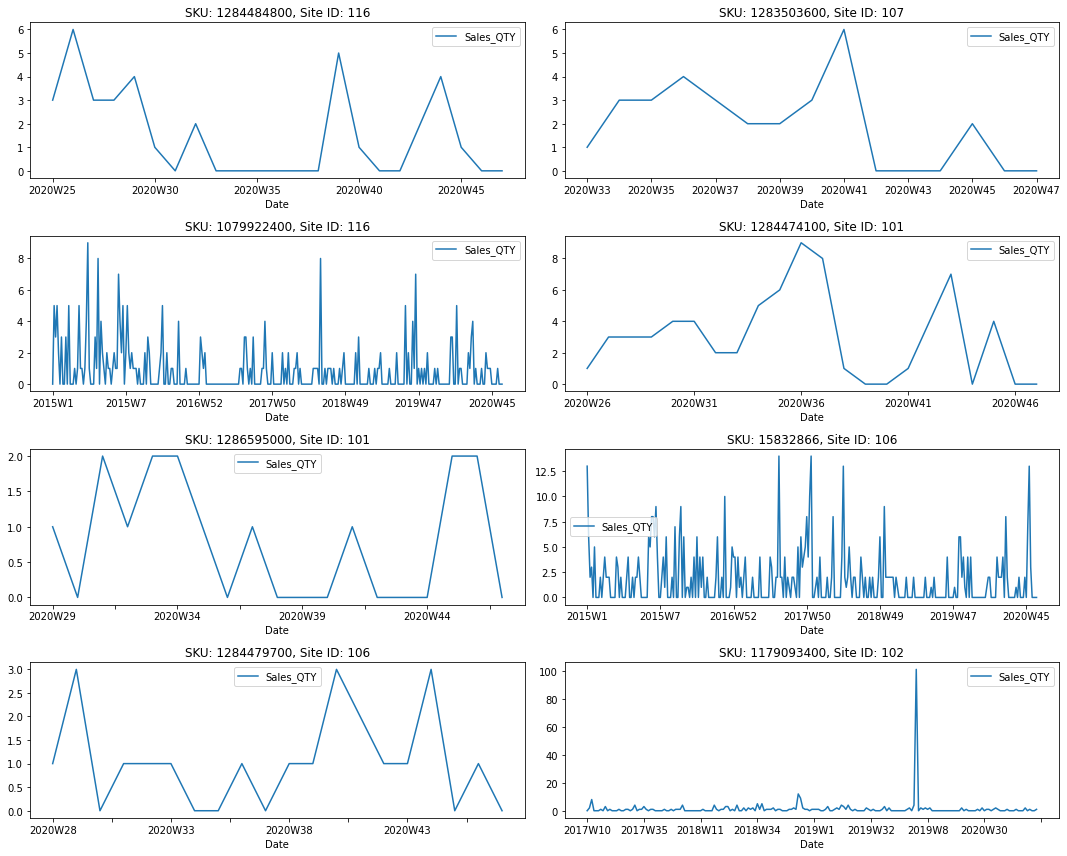

In [10]:
classification = 'A'
samples = df.loc[df.Classification == classification][['Site_ID','SKU']].drop_duplicates().sample(n=n_series, random_state=4).values.tolist()
plot_timeseries(samples, df)

## Class B (Medium Seller)

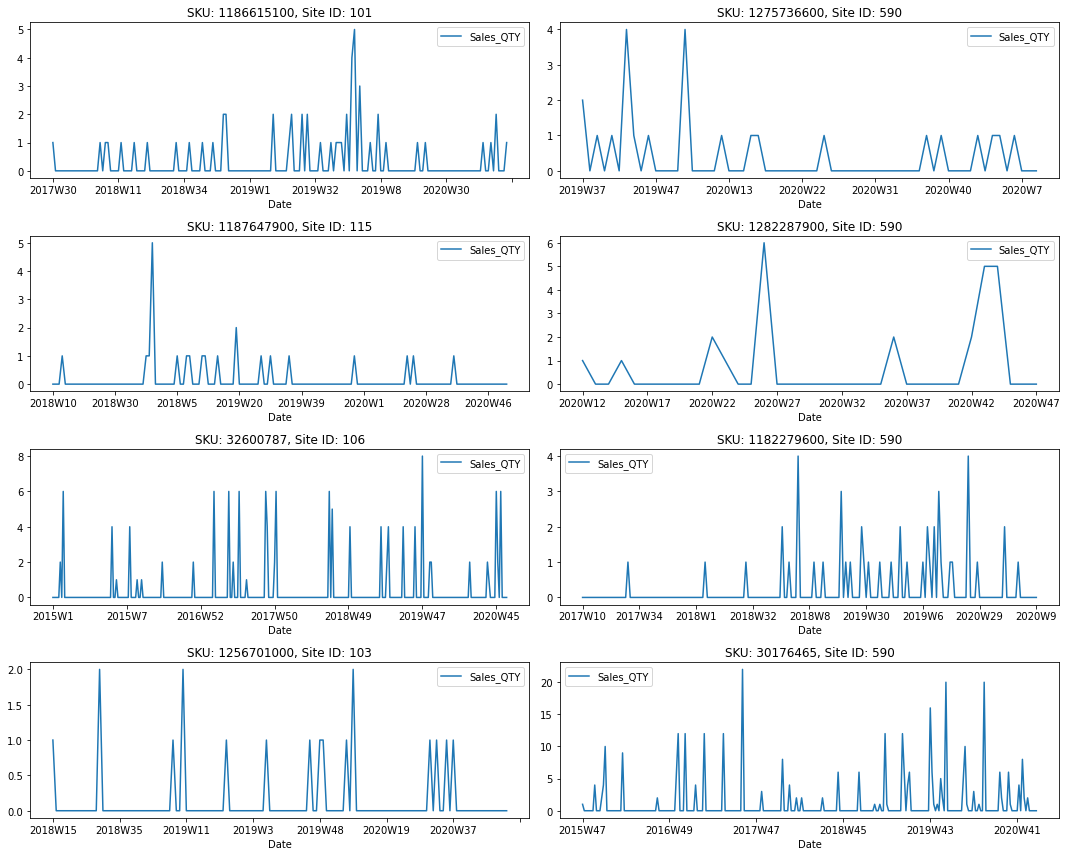

In [11]:
classification = 'B'
samples = df.loc[df.Classification == classification][['Site_ID','SKU']].drop_duplicates().sample(n=n_series, random_state=4).values.tolist()
plot_timeseries(samples, df)

## Class C (Low Seller)

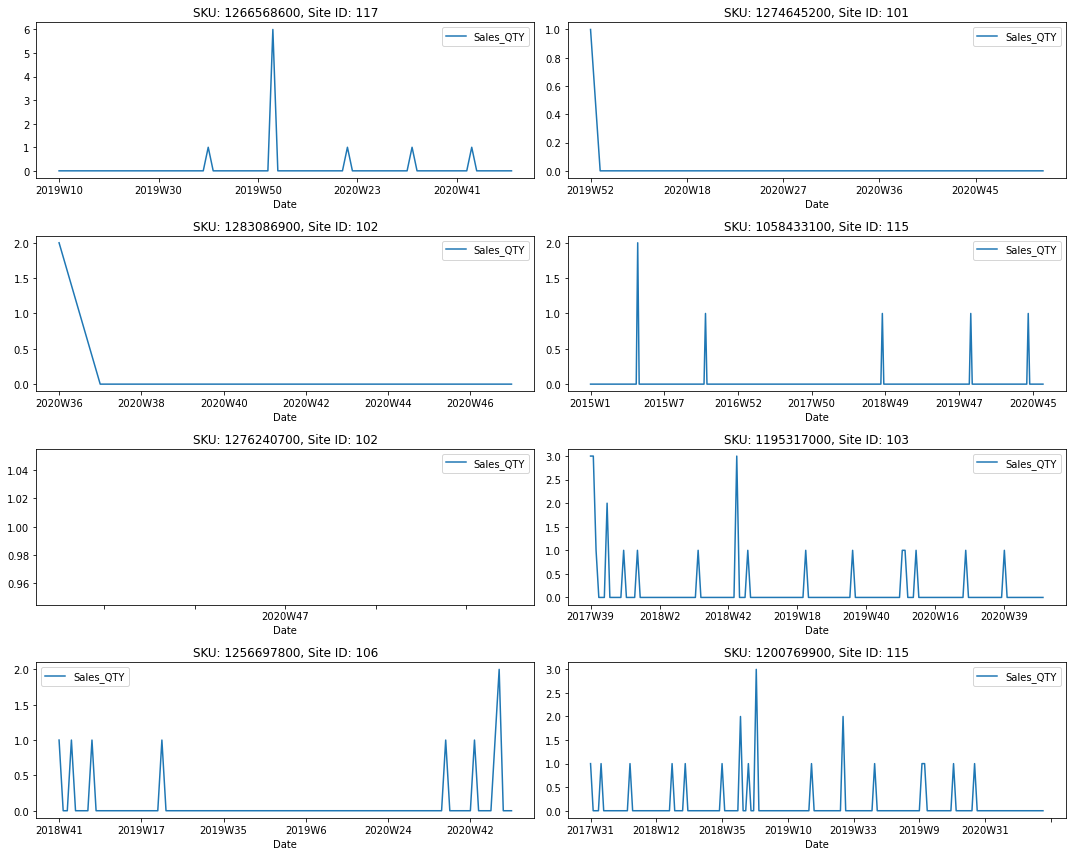

In [12]:
classification = 'C'
samples = df.loc[df.Classification == classification][['Site_ID','SKU']].drop_duplicates().sample(n=n_series, random_state=4).values.tolist()
plot_timeseries(samples, df)

# Feature Engineering

In [13]:
df['rolling_mean_w4'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1).rolling(window=4,min_periods=0).mean()).fillna(0)

df['rolling_mean_w8'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1).rolling(window=8,min_periods=0).mean()).fillna(0)

df['lag_w1'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1))

df['lag_w2'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(2))

df['lag_w3'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(3))

df['lag_w4'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(4))

df['lag_y1'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(52))

df['lag_y2'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(104))


In [14]:
cat_features = [
'Week', 'Year', 'Site_ID', 'SKU','Season_Year',
       'Vendor_ID', 'Price_Level', 'Web_Article', 'CENSHARE_CAT_1',
       'CENSHARE_CAT_2', 'CENSHARE_CAT_3'
]

num_features = [
'rolling_mean_w4', 'lag_w1',
       'lag_w2', 'lag_w3', 'lag_w4', 'lag_y1', 'lag_y2'
]

features = cat_features + num_features

In [15]:
# Convert categorical features to integers 
df = utils.encode_categorical(df, cat_features, downcast_cols=False)

# Forecasting

In [16]:
splits = utils.get_splits(df, fh=forecast_horizon, n_splits=1)

In [17]:
# Store results in dataframe and validate the error at the end.
result_df = pd.DataFrame(columns=['Week', 'Year', 'Site_ID', 'SKU','Prediction']+[target_variable] )

In [18]:
split_criteria = 'CENSHARE_CAT_1'

df[[split_criteria]].value_counts()

CENSHARE_CAT_1
9                 2204625
16                1874316
14                 989654
0                  830839
18                 749001
2                  740394
6                  313464
12                 250714
15                 212854
4                   86688
11                  64426
13                  51284
3                   31894
10                  22208
8                   13629
1                    2095
7                    1148
5                     409
17                    190
dtype: int64

## Class A (Top Seller)

In [19]:
model_params = {
    'seed': 10,
    'objective': 'poisson',
    'metric': 'rmse',
    'num_leaves': 2^4,
    'max_bin': 1000,
    }

In [20]:
rmse = []



save_models = False

for week, year in splits:
    for split in df[split_criteria].drop_duplicates():
        print(f'\n\n****** {year}W{week} ******')
        print(f'****** Split Criteria: {split_criteria} = {i} ******')
        
        df_class = df.loc[df.Classification == 'A'].loc[df[split_criteria] == split].copy()
        if df_class.empty:
            continue
        
        evals_result = {}

        week=int(week)
        year=int(year)

        # Train data: same year and past week OR past year
        x_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][features]
        y_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][target_variable]

        x_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][features]
        y_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][target_variable]



        train_data = lgb.Dataset(x_train, label=y_train,
                                 categorical_feature=cat_features, free_raw_data=False,
                               )
        validation_data = lgb.Dataset(
            x_test, label=y_test, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
        )



        gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                        evals_result=evals_result, num_boost_round=1000,
                        verbose_eval=25, early_stopping_rounds=20,
                       )


        y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)


        if save_models:
            print('log: save model and evals result')
            gbm.save_model(path_models + f'gbm_{year}w{week}.txt', num_iteration=gbm.best_iteration) 

            evals_result_p = open(path_models+ f'evals_result_{year}w{week}.pkl', 'wb')
            pickle.dump(evals_result, evals_result_p)
            evals_result_p.close()

        rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        
        # Gather results of this article category and store them in general result_df
        result_class = x_test[['Week', 'Year', 'Site_ID', 'SKU']].copy()
        result_class[target_variable] = list(y_test)
        result_class['Prediction'] = list(y_pred)


        result_df = result_df.append(result_class)
        
        # Clear Cell Output
        clear_output()

In [21]:
print('RMSE:\n', rmse)
    
print('\nCrossvalidated RMSE: ', np.mean(rmse))

RMSE:
 [51.62286323108768, 71.21734392896971, 95.33803393791636, 38.21827582219615, 8.032890389606608, 112.00385162165666, 102.20046622292588, 14.799041898387646, 47.78343480163116, 101.32046941759543, 23.91535330397752, 58.30459721651135, 54.762493708382046, 225.9892021687462, 46.734052063963446, 9.737891209948547, 60.58202951406647]

Crossvalidated RMSE:  66.03307590926876


In [22]:
result_df

,Week,Year,Site_ID,SKU,Prediction,Turnover
307,46,5,0,0,32.703613,29.900000
3034,46,5,0,1,20.781631,0.000000
5409,46,5,0,2,19.651486,0.000000
8097,46,5,0,3,51.940374,0.000000
9329,46,5,4,3,49.319050,0.000000
...,...,...,...,...,...,...
8383452,46,5,0,8973,100.902334,24.900000
8383496,46,5,0,8974,100.902334,105.040001
8383530,46,5,0,8975,100.902334,149.500000
8383565,46,5,0,8976,100.902334,104.699997


## Class B (Medium Seller)

In [23]:
model_params = {
    'seed': 10,
    'objective': 'poisson',
    'metric': 'rmse',
    'num_leaves': 2^4,
    'max_bin': 1000,
    }

In [24]:
rmse = []



save_models = False

for week, year in splits:
    for split in df[split_criteria].drop_duplicates():
        print(f'\n\n****** {year}W{week} ******')
        print(f'****** Split Criteria: {split_criteria} = {i} ******')
        
        df_class = df.loc[df.Classification == 'B'].loc[df[split_criteria] == split].copy()
        if df_class.empty:
            continue
        
        evals_result = {}

        week=int(week)
        year=int(year)

        # Train data: same year and past week OR past year
        x_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][features]
        y_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][target_variable]

        x_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][features]
        y_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][target_variable]



        train_data = lgb.Dataset(x_train, label=y_train,
                                 categorical_feature=cat_features, free_raw_data=False,
                               )
        validation_data = lgb.Dataset(
            x_test, label=y_test, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
        )



        gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                        evals_result=evals_result, num_boost_round=1000,
                        verbose_eval=25, early_stopping_rounds=20,
                       )


        y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)


        if save_models:
            print('log: save model and evals result')
            gbm.save_model(path_models + f'gbm_{year}w{week}.txt', num_iteration=gbm.best_iteration) 

            evals_result_p = open(path_models+ f'evals_result_{year}w{week}.pkl', 'wb')
            pickle.dump(evals_result, evals_result_p)
            evals_result_p.close()

        rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        
        # Gather results of this article category and store them in general result_df
        result_class = x_test[['Week', 'Year', 'Site_ID', 'SKU']].copy()
        result_class[target_variable] = list(y_test)
        result_class['Prediction'] = list(y_pred)


        result_df = result_df.append(result_class)
        
        # Clear Cell Output
        clear_output()



****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = (590, 1288785900) ******


In [25]:
print('RMSE:\n', rmse)
    
print('\nCrossvalidated RMSE: ', np.mean(rmse))

RMSE:
 [74.75026918780104, 56.53639076821931, 78.30115616073294, 26.610183699363986, 27.73596691864162, 99.73816299386885, 44.52013808616754, 18.436501883107216, 66.95742136216359, 71.21558647327535, 100.73894428785424, 26.62794101908916, 137.1049259415494, 81.17128065292346, 10.111456099854431, 8.55374358654319, 111.94088355268073, 10.784700772270257]

Crossvalidated RMSE:  58.43531408033924


In [26]:
result_df

,Week,Year,Site_ID,SKU,Prediction,Turnover
307,46,5,0,0,32.703613,29.9
3034,46,5,0,1,20.781631,0.0
5409,46,5,0,2,19.651486,0.0
8097,46,5,0,3,51.940374,0.0
9329,46,5,4,3,49.319050,0.0
...,...,...,...,...,...,...
7198957,46,5,8,4318,9.594087,0.0
8257908,46,5,0,8000,5.984377,0.0
8258008,46,5,2,8000,5.984377,24.9
8258076,46,5,4,8000,5.984377,0.0


## Class C (Low Seller)

In [27]:
rmse = []



save_models = False

for week, year in splits:
    for split in df[split_criteria].drop_duplicates():
        print(f'\n\n****** {year}W{week} ******')
        print(f'****** Split Criteria: {split_criteria} = {i} ******')
        
        df_class = df.loc[df.Classification == 'C'].loc[df[split_criteria] == split].copy()
        if df_class.empty:
            continue
        
        evals_result = {}

        week=int(week)
        year=int(year)

        # Train data: same year and past week OR past year
        x_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][features]
        y_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][target_variable]

        x_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][features]
        y_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][target_variable]



        train_data = lgb.Dataset(x_train, label=y_train,
                                 categorical_feature=cat_features, free_raw_data=False,
                               )
        validation_data = lgb.Dataset(
            x_test, label=y_test, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
        )



        gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                        evals_result=evals_result, num_boost_round=1000,
                        verbose_eval=25, early_stopping_rounds=20,
                       )


        y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)


        if save_models:
            print('log: save model and evals result')
            gbm.save_model(path_models + f'gbm_{year}w{week}.txt', num_iteration=gbm.best_iteration) 

            evals_result_p = open(path_models+ f'evals_result_{year}w{week}.pkl', 'wb')
            pickle.dump(evals_result, evals_result_p)
            evals_result_p.close()

        rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        
        # Gather results of this article category and store them in general result_df
        result_class = x_test[['Week', 'Year', 'Site_ID', 'SKU']].copy()
        result_class[target_variable] = list(y_test)
        result_class['Prediction'] = list(y_pred)


        result_df = result_df.append(result_class)
        
        # Clear Cell Output
        clear_output()

In [28]:
print('RMSE:\n', rmse)
    
print('\nCrossvalidated RMSE: ', np.mean(rmse))

RMSE:
 [239.84708003061846, 35.61657868486936, 52.72702686733016, 20.641890640533063, 15.874123928127021, 87.60618099424424, 36.75504988515448, 13.267811017942359, 38.908352368289485, 64.05496117658376, 18.47595182040472, 39.51968948805011, 82.03269512636047, 67.98445282741287, 66.10581423575681, 0.009697341821831079, 0.7679116741460678, 114.78054376821723]

Crossvalidated RMSE:  55.276433993103474


In [29]:
result_df

,Week,Year,Site_ID,SKU,Prediction,Turnover
307,46,5,0,0,32.703613,29.900000
3034,46,5,0,1,20.781631,0.000000
5409,46,5,0,2,19.651486,0.000000
8097,46,5,0,3,51.940374,0.000000
9329,46,5,4,3,49.319050,0.000000
...,...,...,...,...,...,...
8383615,46,5,4,8977,76.566424,79.199997
8383621,46,5,5,8977,54.327838,0.000000
8383625,46,5,6,8977,38.668586,0.000000
8383630,46,5,7,8977,78.065214,59.400002


## Validate Overall Performance

In [30]:
mean_squared_error(result_df.Prediction, result_df.Turnover, squared=False)

96.03086995992179